In [2]:
import pandas as pd
import numpy as np
import urllib.parse
import urllib.request
from tqdm import tqdm
import os
import time
import subprocess
from scipy import stats
import matplotlib.pyplot as plt

def uniprotMapping(query, From="ACC",To="ACC",Format="fasta",Columns="",outputDir=""):
    for i in range(10):
        try:
            url = 'https://www.uniprot.org/uploadlists/'
            params={
                "query":query,
                "from":From,
                "to":To,
                "format":Format,
                "columns":Columns,
            }
            data = urllib.parse.urlencode(params)
            data = data.encode('utf-8')
            req = urllib.request.Request(url, data)
            with urllib.request.urlopen(req) as f:
                response = str(f.read(),encoding="utf-8")
            fileName="{}_{}_{}.{}".format(query.replace("\n",""),From,To,Format)
            outputPath="{}{}".format(outputDir,fileName)
            if outputDir and not os.path.exists(outputDir):
                os.makedirs(outputDir)
            with open(outputPath,"w") as f:
                f.write(response)
            return response
        except:
            print("request failed, wait for", i*5,"seconds and try again")
            time.sleep(i*5)
            
def cdhit(inputFastaFile, identity=0.9, outputDir="",verbose=False):
    if outputDir and not os.path.exists(outputDir):
        os.makedirs(outputDir)
    outputFile=inputFastaFile.split("/")[-1].replace(".fasta","_cdhit{}.fasta".format(identity))
    outputFilePath="{}{}".format(outputDir,outputFile)
    command = "cd-hit -i {} -o {} -c {}  -n 2 -M 1500".format(inputFastaFile,outputFilePath,identity)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    if verbose:
        print(cmd.communicate())
    else:
        cmd.communicate()
    return outputFilePath

def clustalo(inputFastaFile,outputDir=""):
    if outputDir and not os.path.exists(outputDir):
        os.makedirs(outputDir)
    outputFile=inputFastaFile.split("/")[-1].replace(".fasta","_MSA.fasta")
    outputFilePath="{}{}".format(outputDir,outputFile)
    command = "clustalo -i {} -o {} --force".format(inputFastaFile,outputFilePath)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    cmd.communicate()
    return outputFilePath

def parseFasta(fastaFile):
    f=open(fastaFile)
    fastaStr=f.read()
    f.close()
    lol=[entry.replace("\n","toSplit",1).replace("\n","").split("toSplit")
        for entry
        in fastaStr[1:].split(">")]
    lol=[(entry.split("|")[:2][-1],seq) for entry,seq in lol]
    dic={entry:sequence for entry,sequence in lol}
    return dic

def writeFasta(fastaFile,fastaDic):
    f=open(fastaFile,"w")
    for key,seq in fastaDic.items():
        toWrite=">{}\n{}\n".format(key,seq)
        f.write(toWrite)
    f.close()
    return fastaFile

def putFirstInFasta(fastaFile,Id):
    dic = parseFasta(fastaFile)
    fastaOrdered = [(key,seq) for key,seq in dic.items() if key==Id] + [(key,seq) for key,seq in dic.items() if key!=Id]
    toWrite=""
    for key,seq in fastaOrdered:
        toWrite+=">{}\n{}\n".format(key,seq)
    with open(fastaFile,"w") as f:
        f.write(toWrite)
        
def getMsaPeridictions(msaFile, verbose=False):
    OutputFile=msaFile.replace(".fasta","_EFoldMine.pred")
    
    command = "python2 efoldminePredictionsMsa.py {} {}".format(msaFile,OutputFile)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    if verbose:
        print(cmd.communicate())
    else:
        cmd.communicate()
    return OutputFile

def msaPredictions2Dic(msaPredictionFile):
    with open(msaPredictionFile) as f:
        msaPredictionString=f.read()
    msaPredictionDic=dict()
    for line in msaPredictionString.split("\n"):
        if line.startswith(">"):
            Id=line.replace(">","")
            msaPredictionDic[Id]=dict()
        else:
            if line:
                feature, featureSequence = line.split("\t")
                if feature=="sequence":
                    msaPredictionDic[Id][feature]=featureSequence.split(" ")
                else:
                    msaPredictionDic[Id][feature]=[float(elm) 
                                                   for elm 
                                                   in featureSequence.split(" ")]
    return msaPredictionDic

def findRelPosInMsa(msaSeq, pos):
        seq = msaSeq
        msaPos=0
        i=0
        while i<=pos:
            msaPos+=1
            if seq[msaPos]!="-":
                i+=1
        return msaPos
    
def cutPredictions(predictionDic,start=None,end=None):
    predictionDicNew=dict()
    for ID in predictionDic.keys():
        predictionDicNew[ID]=dict()
        for feature,seqList in predictionDic[ID].items():
            predictionDicNew[ID][feature]=seqList[start:end]
    return predictionDicNew

def writePredictions2File(predictionDic,fileName):
    with open(fileName,"w") as f:
        for ID in predictionDic.keys():
            f.write(">{}\n".format(ID))
            for feature,seqList in predictionDic[ID].items():
                seqListOfStrings=map(str,seqList)
                seqStr=" ".join(seqListOfStrings)
                f.write("{}\t{}\n".format(feature,seqStr))
    return fileName

def msaPredictionsDic2Arrays(msaPredictionDic):
    Ids =  sorted(msaPredictionDic.keys())
    features = sorted(msaPredictionDic[Ids[0]].keys())
    cols = len(msaPredictionDic[Ids[0]][features[0]])
    rows = len(Ids)
    
    dicOfArrays=dict()
    for feature in features:
        if feature=="sequence":
            dicOfArrays[feature]=np.zeros((rows,cols),dtype=str)
            dicOfArrays[feature][:,:]="-"
        else:
            dicOfArrays[feature]=np.zeros((rows,cols),dtype=float)
            dicOfArrays[feature][:,:]=np.nan
            
    for i,Id in enumerate(Ids):
        for feature in features:
            dicOfArrays[feature][i,:]=msaPredictionDic[Id][feature]
    return dicOfArrays

def wilcoxonRanksumTest(periplasm,cytoplasm,pValue=5e-2,minDataSize=10):
    features = [feature for feature in periplasm.keys() if feature!="sequence"]
    rows, cols = periplasm[features[0]].shape
    
    wilcoxonResults=dict()
    
    for feature in features:
        wilcoxonResults[feature]=list()
        for i in range(cols):
            cytoData=[value for value in cytoplasm[feature][:,i] if not np.isnan(value)]
            periData=[value for value in periplasm[feature][:,i] if not np.isnan(value)]
            if len(cytoData)<minDataSize or len(periData)<minDataSize:
                wilcoxonResults[feature].append(float("nan"))
            else:
                statistic, pValue_observed = stats.ranksums(cytoData,periData)
                if pValue_observed > pValue:
                    wilcoxonResults[feature].append(0)
                else:
                    wilcoxonResults[feature].append(statistic)
    return wilcoxonResults

def getMedian(wilcoxonResults):
    arrays=dict()
    ids = sorted(wilcoxonResults.keys())
    features= sorted(wilcoxonResults[ids[0]])
    longest = max(map(len, [wilcoxonResults[Id][features[0]] for Id in ids]))
    for feature in features:
        arrays[feature]=np.zeros((len(ids),longest))
        arrays[feature][:,:]=np.nan
    for i,Id in enumerate(ids):
        for feature in features:
            values = wilcoxonResults[Id][feature]
            arrays[feature][i,:len(values)]=values
    medians=dict()
    for i,Id in enumerate(ids):
        for feature in features:
            medians[feature]=np.nanmedian(arrays[feature],axis=0)
    return medians

def getPercentile(wilcoxonResults, percentile=25):
    arrays=dict()
    ids = sorted(wilcoxonResults.keys())
    features= sorted(wilcoxonResults[ids[0]])
    longest = max(map(len, [wilcoxonResults[Id][features[0]] for Id in ids]))
    for feature in features:
        arrays[feature]=np.zeros((len(ids),longest))
        arrays[feature][:,:]=np.nan
    for i,Id in enumerate(ids):
        for feature in features:
            values = wilcoxonResults[Id][feature]
            arrays[feature][i,:len(values)]=values
    Percentile=dict()
    for i,Id in enumerate(ids):
        for feature in features:
            Percentile[feature]=np.nanpercentile(arrays[feature],percentile,axis=0)
    return Percentile

def writeWilcoxonResults(file,wilcoxonResults,cyto_id, peri_id):
    f=open(file,"a")
    f.write(">{}|{}\n".format(cyto_id, peri_id))
    for feature,sequence in wilcoxonResults.items():
        sequenceString=" ".join([str(elm) for elm in sequence])
        f.write("{}\t{}\n".format(feature,sequenceString))
    f.close()


In [10]:
"""  Parse periplamic protein sequences """
PERIPLASM = pd.read_csv("periplasm.tab",sep="\t")
PERIPLASM["Signal peptide"]=PERIPLASM["Signal peptide"].apply(
    lambda x : np.array(x.split(";")[0].split(" ")[-1].split(".."),dtype=int)-1)

""" Generate fasta from dataframe"""
F = open("periplasm.fasta","w")
for I,ROW in tqdm(PERIPLASM.iterrows()):
    ENTRY = ROW["Entry"]
    SEQ = ROW["Sequence"]
    SP_START = ROW["Signal peptide"][0]
    SP_END = ROW["Signal peptide"][1]
    
    TO_WRITE=">{} {} {}\n{}\n".format(ENTRY,SP_START,SP_END,SEQ)
    F.write(TO_WRITE)
F.close()

109278it [00:42, 2544.49it/s]


In [ ]:
""" Use CD-HIT to cluster sequences """
PERIPLASM_FILE="periplasm.fasta"
PERIPLASM_CDHIT = cdhit(PERIPLASM_FILE,identity=0.5)

In [ ]:
""" Generate periplasmic FASTA without SP"""
PERI_DIC=parseFasta("periplasm_cdhit0.5.fasta")
F = open("periplasm_without_SP_cdhit0.5.fasta","w")
for KEY,SEQ in PERI_DIC.items():
    NEW_START = int(KEY.split(" ")[-1])+1
    TO_WRITE=">{}\n{}\n".format(KEY,SEQ[NEW_START:])
    F.write(TO_WRITE)
F.close()

In [ ]:
%%time
""" Run predictions on reduced fastsa files """
for FILE in [
    "cytoplasm_cdhit0.5.fasta", 
    "periplasm_cdhit0.5.fasta",
    "periplasm_without_SP_cdhit0.5.fasta"]:
    print(FILE)
    getMsaPeridictions(FILE)

In [ ]:
""" Run predictions on reduced fastsa files """
for FILE in ["periplasm_without_SP_cdhit0.5.fasta"]:
    print(FILE)
    getMsaPeridictions(FILE)

In [3]:
%%time
""" Read predictions and store in dictionary """
CYTOPLASM_PRED_DIC = msaPredictions2Dic("cytoplasm_cdhit0.5_EFoldMine.pred")
print(len(CYTOPLASM_PRED_DIC))
PERIPLASM_WITOUT_SP_PRED_DIC = msaPredictions2Dic("periplasm_without_SP_cdhit0.5_EFoldMine.pred")
print(len(PERIPLASM_WITOUT_SP_PRED_DIC))
PERIPLASM_SP_PRED_DIC = msaPredictions2Dic("periplasm_cdhit0.5_EFoldMine.pred")
print(len(PERIPLASM_SP_PRED_DIC))

30632
3883
3883
CPU times: user 1min 8s, sys: 6.45 s, total: 1min 15s
Wall time: 1min 41s


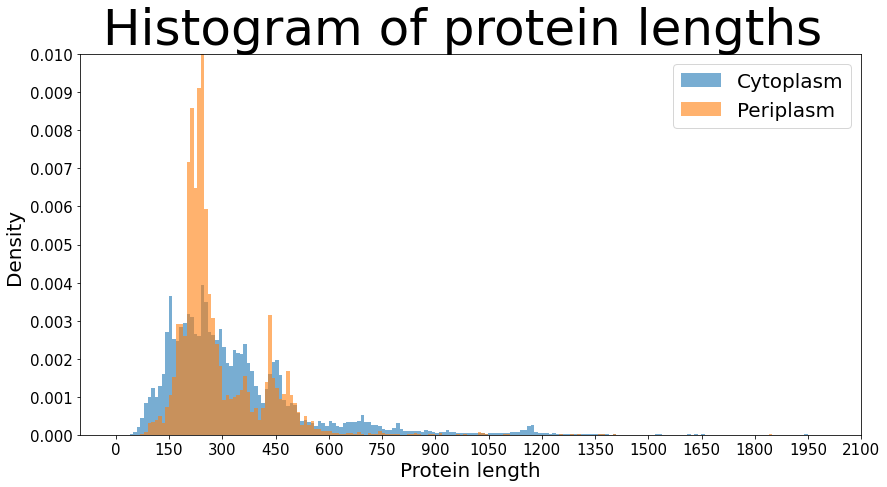

In [4]:
""" Plot histogram of protein lengths """
CYTO_LENGTHS = sorted(map(len,[CYTOPLASM_PRED_DIC[KEY]["sequence"] for KEY in CYTOPLASM_PRED_DIC.keys()]))
PERI_LENGTHS = sorted(map(len,[PERIPLASM_SP_PRED_DIC[KEY]["sequence"] for KEY in PERIPLASM_SP_PRED_DIC.keys()]))
PERI_WITHOUT_LENGTHS = sorted(map(len,[PERIPLASM_WITOUT_SP_PRED_DIC[KEY]["sequence"] for KEY in PERIPLASM_WITOUT_SP_PRED_DIC.keys()]))
plt.figure(figsize=(14,7))
plt.hist(CYTO_LENGTHS,bins=np.arange(-0.5,2000.5,10),label="Cytoplasm",density=True,alpha=0.6)
plt.hist(PERI_LENGTHS,bins=np.arange(-0.5,2000.5,10),label="Periplasm",density=True,alpha=0.6)
plt.title("Histogram of protein lengths ",fontsize=50)
plt.xlabel("Protein length",fontsize=20)
plt.xticks(list(np.arange(0,2150,150)),fontsize=15)
plt.ylabel("Density ",fontsize=20)
plt.ylim((0,0.01))
plt.yticks(np.arange(0,0.011,0.001),fontsize=15)
plt.legend(fontsize=20)
plt.savefig("protein_lengths.pdf")
plt.show()

In [4]:
""" Generate pandas summary """
PERI_SUMMARY = pd.DataFrame(PERI_LENGTHS).describe().astype(int)
CYTO_SUMMARY = pd.DataFrame(CYTO_LENGTHS).describe().astype(int)
SUMMARY=pd.DataFrame()
SUMMARY[["Cytoplasm"]] = CYTO_SUMMARY
SUMMARY[["Periplasm"]] = PERI_SUMMARY
SUMMARY.to_html("protein_lenghts.html")
!pandoc -i "protein_lenghts.html" -o "protein_lenghts.tex"
print(stats.ranksums(PERI_LENGTHS, CYTO_LENGTHS))
SUMMARY

RanksumsResult(statistic=-10.215350925927016, pvalue=1.692655526514401e-24)


,Cytoplasm,Periplasm
count,30632,3883
mean,336,286
std,212,125
min,42,78
25%,200,213
50%,283,244
75%,409,330
max,3326,1849


In [5]:
                                # Count Amino acid in Cytoplasm
CYTO_COUNTS=dict()
for ID in tqdm(CYTOPLASM_PRED_DIC.keys()):
    for RESIDUE in CYTOPLASM_PRED_DIC[ID]["sequence"]:
        if RESIDUE in CYTO_COUNTS.keys():
            CYTO_COUNTS[RESIDUE]+=1
        else:
            CYTO_COUNTS[RESIDUE]=1
CYTO_COUNTS_DF = pd.DataFrame({"Cytoplasm":CYTO_COUNTS})
CYTO_COUNTS_DF["Cytoplasm"] = CYTO_COUNTS_DF["Cytoplasm"] / np.sum(CYTO_COUNTS_DF["Cytoplasm"])
CYTO_COUNTS_DF

100%|██████████| 30632/30632 [00:04<00:00, 6485.49it/s]


,Cytoplasm
A,9.160556e-02
C,1.281484e-02
D,5.701431e-02
E,6.476281e-02
F,3.561775e-02
G,6.647551e-02
H,2.544600e-02
I,6.280592e-02
K,5.282512e-02
L,1.072319e-01


In [6]:
# Count Amino acid in periplasm
PERI_COUNTS=dict()
for ID in tqdm(PERIPLASM_SP_PRED_DIC.keys()):
    for RESIDUE in PERIPLASM_SP_PRED_DIC[ID]["sequence"]:
        if RESIDUE in PERI_COUNTS.keys():
            PERI_COUNTS[RESIDUE]+=1
        else:
            PERI_COUNTS[RESIDUE]=1
PERI_COUNTS_DF = pd.DataFrame({"Periplasm":PERI_COUNTS})
PERI_COUNTS_DF["Periplasm"] = PERI_COUNTS_DF["Periplasm"] / np.sum(PERI_COUNTS_DF["Periplasm"])
PERI_COUNTS_DF

100%|██████████| 3883/3883 [00:00<00:00, 5487.61it/s]


,Periplasm
A,1.005935e-01
C,7.008400e-03
D,5.518924e-02
E,5.682935e-02
F,3.631764e-02
G,6.649137e-02
H,1.639572e-02
I,5.493699e-02
K,5.298447e-02
L,9.550527e-02


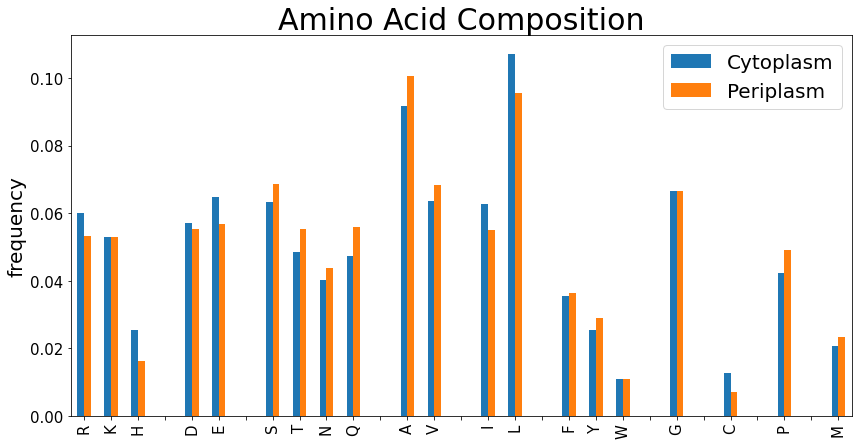

In [7]:
""" Visualise difference in amino acid composition """
AMINO_ACIDS = CYTO_COUNTS_DF.join(PERI_COUNTS_DF).drop(["Z","X"])\
.reindex(index = ["R","K","H","","D","E","","S","T","N","Q","","A","V","","I","L","","F","Y","W","","G","","C","","P","","M"])

fig, ax = plt.subplots(figsize=(14,7))

AMINO_ACIDS.plot.bar(ax=ax)

plt.title("Amino Acid Composition", fontsize=30)
plt.ylabel("frequency",fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=20)

plt.savefig("amino_acid_composition.pdf")

plt.show()

100%|██████████| 6/6 [00:22<00:00,  3.67s/it]


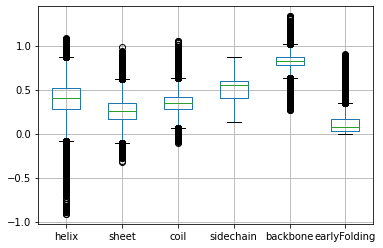

In [8]:
""" Make summary list of cytoplasm predictions """
CYTO_GLOBAL_FEATURES=dict()
FEATURES = ['helix','sheet','coil', 'sidechain', 'backbone', 'earlyFolding']
for FEATURE in FEATURES:
    CYTO_GLOBAL_FEATURES[FEATURE]=list()
for ID in tqdm(CYTOPLASM_PRED_DIC.keys()):
    for FEATURE in FEATURES:
        CYTO_GLOBAL_FEATURES[FEATURE]+=CYTOPLASM_PRED_DIC[ID][FEATURE]
CYTO_GLOBAL_FEATURES_DF=pd.DataFrame()
for FEATURE in tqdm(FEATURES):
    CYTO_GLOBAL_FEATURES_DF[[FEATURE]]=pd.DataFrame(CYTO_GLOBAL_FEATURES[FEATURE])
CYTO_GLOBAL_FEATURES_DF[["location"]]=pd.DataFrame(["Cytoplasm"]*len(CYTO_GLOBAL_FEATURES_DF))
CYTO_GLOBAL_FEATURES_DF.boxplot(FEATURES)

100%|██████████| 3883/3883 [00:00<00:00, 10245.04it/s]


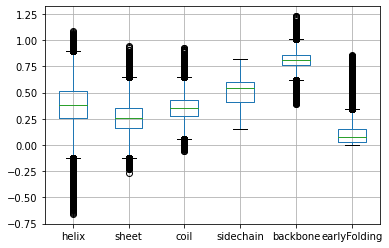

In [9]:
""" Make summary list of periplasm predictions """
PERI_GLOBAL_FEATURES=dict()
FEATURES = ['helix','sheet','coil', 'sidechain', 'backbone', 'earlyFolding']
for FEATURE in FEATURES:
    PERI_GLOBAL_FEATURES[FEATURE]=list()
for ID in tqdm(PERIPLASM_SP_PRED_DIC.keys()):
    for FEATURE in FEATURES:
        PERI_GLOBAL_FEATURES[FEATURE]+=PERIPLASM_SP_PRED_DIC[ID][FEATURE]
PERI_GLOBAL_FEATURES_DF=pd.DataFrame()
for FEATURE in FEATURES:
    PERI_GLOBAL_FEATURES_DF[[FEATURE]]=pd.DataFrame(PERI_GLOBAL_FEATURES[FEATURE])
PERI_GLOBAL_FEATURES_DF[["location"]]=pd.DataFrame(["Periplasm"]*len(PERI_GLOBAL_FEATURES_DF))
PERI_GLOBAL_FEATURES_DF.boxplot(FEATURES)

In [10]:
""" Combine feature dataframes """
GLOBAL_FEATURES_DF = pd.concat([CYTO_GLOBAL_FEATURES_DF, PERI_GLOBAL_FEATURES_DF])
FEATURES_VIOLIN = pd.melt(GLOBAL_FEATURES_DF,id_vars=["location"],value_vars=FEATURES,var_name="feature")
FEATURES_VIOLIN

,location,feature,value
0,Cytoplasm,helix,0.375585
1,Cytoplasm,helix,0.365796
2,Cytoplasm,helix,0.357986
3,Cytoplasm,helix,0.354615
4,Cytoplasm,helix,0.329381
...,...,...,...
68548753,Periplasm,earlyFolding,0.220544
68548754,Periplasm,earlyFolding,0.345179
68548755,Periplasm,earlyFolding,0.473256
68548756,Periplasm,earlyFolding,0.555397


In [11]:
68548758 / 6

11424793.0

In [12]:
""" Subsample to test out """
ROWS_SAMPLE = np.random.choice(FEATURES_VIOLIN.index.values, int(1e5))
SAMPLE = FEATURES_VIOLIN.iloc[ROWS_SAMPLE,:]
SAMPLE

,location,feature,value
60067555,Cytoplasm,earlyFolding,0.236176
24267755,Cytoplasm,coil,0.162106
63885378,Cytoplasm,earlyFolding,0.053639
59771769,Cytoplasm,earlyFolding,0.062276
37906426,Cytoplasm,sidechain,0.503300
...,...,...,...
17010959,Cytoplasm,sheet,0.238642
27783212,Cytoplasm,coil,0.397274
60428076,Cytoplasm,earlyFolding,0.008113
4595088,Cytoplasm,helix,0.424135


In [13]:
""" Determine whether  differences are significant """
FEATURES = ['helix','sheet','coil', 'sidechain', 'backbone', 'earlyFolding']
for FEATURE in FEATURES:
    print(FEATURE,":",stats.ranksums(PERI_GLOBAL_FEATURES[FEATURE],CYTO_GLOBAL_FEATURES[FEATURE]))

helix : RanksumsResult(statistic=-74.15768601426721, pvalue=0.0)
sheet : RanksumsResult(statistic=15.935252946365145, pvalue=3.6073804600339776e-57)
coil : RanksumsResult(statistic=33.891196254798956, pvalue=8.980326855075132e-252)
sidechain : RanksumsResult(statistic=-5.994379826889339, pvalue=2.042634490777268e-09)
backbone : RanksumsResult(statistic=-145.8623704245923, pvalue=0.0)
earlyFolding : RanksumsResult(statistic=-50.26797663608709, pvalue=0.0)


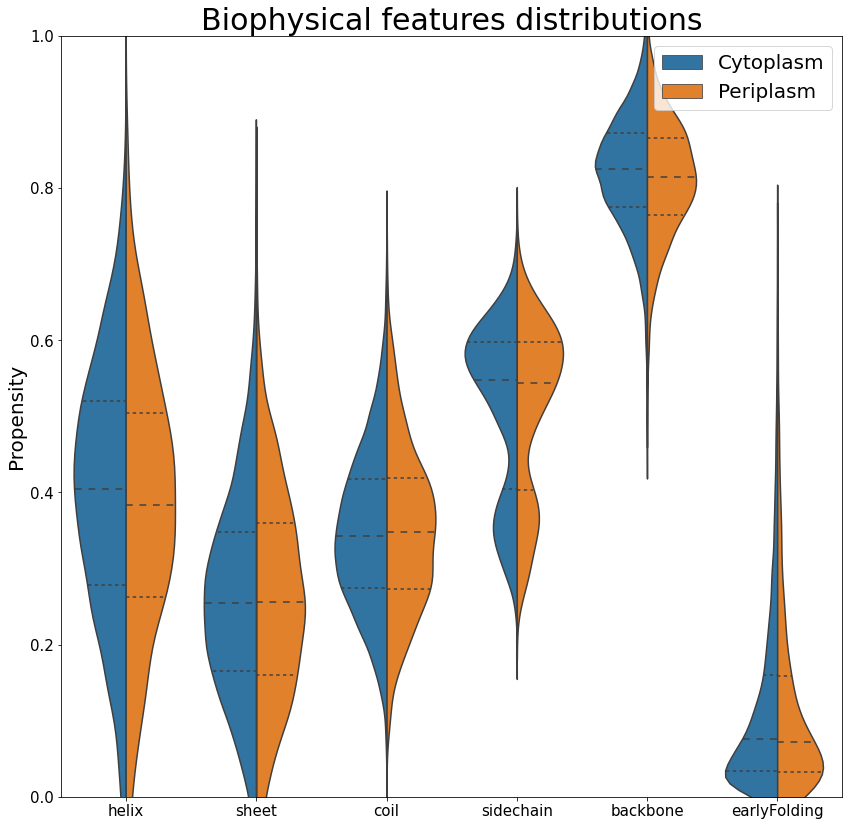

In [15]:
import seaborn as sns
""" Visualise results by violin plot """
plt.figure(figsize=(14,14))

sns.violinplot(x="feature",
               y="value",
               hue="location",
               data=SAMPLE,
               split=True,
              inner="quart",
              order=FEATURES)
               
    
plt.ylim((0,1))    

plt.title("Biophysical features distributions", fontsize=30)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel("")
plt.ylabel("Propensity",fontsize=20)

plt.savefig("features_violin.pdf")
    
plt.show()

In [16]:
FEATURES_VIOLIN["location"].unique()

array(['Cytoplasm', 'Periplasm'], dtype=object)

In [5]:
""" Transform PERI_LENGTHSrediction values to an array """
CYTO_LEN_MAX = np.max(CYTO_LENGTHS)
CYTO_NUMBER = len(CYTOPLASM_PRED_DIC)
CYTO_ARRAYS = dict()
for FEATURE in [KEY for KEY in CYTOPLASM_PRED_DIC[list(CYTOPLASM_PRED_DIC.keys())[0]].keys() if KEY!="sequence"]:
    CYTO_ARRAYS[FEATURE] = dict()
    CYTO_ARRAYS[FEATURE]["values"] = np.zeros((CYTO_NUMBER,CYTO_LEN_MAX))*float("nan")
    for I,ID in tqdm(enumerate(CYTOPLASM_PRED_DIC.keys())):
        predSeq = CYTOPLASM_PRED_DIC[ID][FEATURE]
        CYTO_ARRAYS[FEATURE]["values"][I,:len(predSeq)]=predSeq
    CYTO_ARRAYS[FEATURE]["median"]=np.nanmedian(CYTO_ARRAYS[FEATURE]["values"],axis=0)
    CYTO_ARRAYS[FEATURE]["percentile25"]=np.nanpercentile(CYTO_ARRAYS[FEATURE]["values"],25,axis=0)
    CYTO_ARRAYS[FEATURE]["percentile75"]=np.nanpercentile(CYTO_ARRAYS[FEATURE]["values"],75,axis=0)
        
CYTO_ARRAYS

30632it [00:01, 20414.25it/s]
30632it [00:01, 15600.21it/s]
30632it [00:01, 16213.91it/s]
30632it [00:18, 1639.94it/s]
30632it [00:25, 1186.68it/s]
30632it [00:25, 1181.43it/s]


{'sheet': {'values': array([[0.15262747, 0.2109614 , 0.26772827, ...,        nan,        nan,
                 nan],
         [0.17464599, 0.24085218, 0.29547021, ...,        nan,        nan,
                 nan],
         [0.16062054, 0.11322856, 0.05744982, ...,        nan,        nan,
                 nan],
         ...,
         [0.21830785, 0.2397359 , 0.22723252, ...,        nan,        nan,
                 nan],
         [0.13620117, 0.12739903, 0.13430852, ...,        nan,        nan,
                 nan],
         [0.18204719, 0.20903444, 0.22860563, ...,        nan,        nan,
                 nan]]),
  'median': array([0.20502751, 0.22128028, 0.22933514, ..., 0.50271162, 0.49370414,
         0.42666128]),
  'percentile25': array([0.15568116, 0.15638836, 0.15001588, ..., 0.50271162, 0.49370414,
         0.42666128]),
  'percentile75': array([0.26321402, 0.2970952 , 0.31768043, ..., 0.50271162, 0.49370414,
         0.42666128])},
 'earlyFolding': {'values': array([[0.01746

In [6]:
""" Transform Periplasmic prediction values (without SP) to an array """
PERI_WITHOUT_LEN_MAX = np.max(PERI_WITHOUT_LENGTHS)
PERI_WITHOUT_NUMBER = len(PERIPLASM_WITOUT_SP_PRED_DIC)

PERI_WITHOUT_ARRAYS=dict()
for FEATURE in [KEY for KEY in PERIPLASM_WITOUT_SP_PRED_DIC[list(PERIPLASM_WITOUT_SP_PRED_DIC.keys())[0]].keys() if KEY!="sequence"]:
    PERI_WITHOUT_ARRAYS[FEATURE] = dict()
    PERI_WITHOUT_ARRAYS[FEATURE]["values"] = np.zeros((PERI_WITHOUT_NUMBER,PERI_WITHOUT_LEN_MAX))*float("nan")
    for I,ID in tqdm(enumerate(PERIPLASM_WITOUT_SP_PRED_DIC.keys())):
        predSeq = PERIPLASM_WITOUT_SP_PRED_DIC[ID][FEATURE]
        PERI_WITHOUT_ARRAYS[FEATURE]["values"][I,:len(predSeq)]=predSeq
    PERI_WITHOUT_ARRAYS[FEATURE]["median"]=np.nanmedian(PERI_WITHOUT_ARRAYS[FEATURE]["values"],axis=0)
    PERI_WITHOUT_ARRAYS[FEATURE]["percentile25"]=np.nanpercentile(PERI_WITHOUT_ARRAYS[FEATURE]["values"],25,axis=0)
    PERI_WITHOUT_ARRAYS[FEATURE]["percentile75"]=np.nanpercentile(PERI_WITHOUT_ARRAYS[FEATURE]["values"],75,axis=0) 
    
PERI_WITHOUT_ARRAYS

3883it [00:03, 1005.14it/s]
3883it [00:02, 1583.73it/s]
3883it [00:01, 3459.15it/s]
3883it [00:00, 5486.69it/s]
3883it [00:00, 7648.63it/s]
3883it [00:00, 10844.21it/s]


{'sheet': {'values': array([[0.14009106, 0.19119063, 0.22595081, ...,        nan,        nan,
                 nan],
         [0.10501593, 0.09202057, 0.08498237, ...,        nan,        nan,
                 nan],
         [0.33461708, 0.34767777, 0.32125366, ...,        nan,        nan,
                 nan],
         ...,
         [0.21695405, 0.21778888, 0.20302388, ...,        nan,        nan,
                 nan],
         [0.26167816, 0.32273084, 0.33865178, ...,        nan,        nan,
                 nan],
         [0.26284862, 0.35319623, 0.4128634 , ...,        nan,        nan,
                 nan]]),
  'median': array([0.18881363, 0.18760344, 0.18295857, ..., 0.29062855, 0.27201037,
         0.25264817]),
  'percentile25': array([0.13038397, 0.11807919, 0.09902041, ..., 0.29062855, 0.27201037,
         0.25264817]),
  'percentile75': array([0.2577039 , 0.27176687, 0.2760327 , ..., 0.29062855, 0.27201037,
         0.25264817])},
 'earlyFolding': {'values': array([[0.01842

In [7]:
""" Split signal peptides from periplasmic proteins """
def splitSignalpeptidePredictions(predictionsDic):
    spPreds = dict()
    seqWithoutSpPreds = dict()
    for ID, featureDic in predictionsDic.items():
        newStart=int(ID.split(" ")[-1])+1
        spPreds[ID]=dict()
        seqWithoutSpPreds[ID]=dict()
        for feature,predSeq in featureDic.items():
            spPreds[ID][feature]=predSeq[:newStart]
            seqWithoutSpPreds[ID][feature]=predSeq[newStart:]
    return spPreds,seqWithoutSpPreds

PREDS_SP, PREDS_WITHOUT_SP = splitSignalpeptidePredictions(PERIPLASM_SP_PRED_DIC)

In [8]:
""" Transform Periplasmic prediction values (made with SP, but cut off) to an array """
PERI_WITH_LEN_MAX = np.max(sorted(map(len,[PREDS_WITHOUT_SP[KEY]["sequence"] for KEY in PREDS_WITHOUT_SP.keys()])))
PERI_WITH_NUMBER = len(PREDS_WITHOUT_SP)

PERI_WITH_ARRAYS=dict()
for FEATURE in [KEY for KEY in PREDS_WITHOUT_SP[list(PREDS_WITHOUT_SP.keys())[0]].keys() if KEY!="sequence"]:
    PERI_WITH_ARRAYS[FEATURE] = dict()
    PERI_WITH_ARRAYS[FEATURE]["values"] = np.zeros((PERI_WITH_NUMBER,PERI_WITH_LEN_MAX))*float("nan")
    for I,ID in tqdm(enumerate(PREDS_WITHOUT_SP.keys())):
        predSeq = PREDS_WITHOUT_SP[ID][FEATURE]
        PERI_WITH_ARRAYS[FEATURE]["values"][I,:len(predSeq)]=predSeq
    PERI_WITH_ARRAYS[FEATURE]["median"]=np.nanmedian(PERI_WITH_ARRAYS[FEATURE]["values"],axis=0)
    PERI_WITH_ARRAYS[FEATURE]["percentile25"]=np.nanpercentile(PERI_WITH_ARRAYS[FEATURE]["values"],25,axis=0)
    PERI_WITH_ARRAYS[FEATURE]["percentile75"]=np.nanpercentile(PERI_WITH_ARRAYS[FEATURE]["values"],75,axis=0)

PERI_WITH_ARRAYS

3883it [00:00, 12371.30it/s]
3883it [00:00, 15888.46it/s]
3883it [00:00, 15286.06it/s]
3883it [00:00, 17557.92it/s]
3883it [00:00, 14887.82it/s]
3883it [00:00, 20001.99it/s]


{'sheet': {'values': array([[ 0.10573952,  0.13653682,  0.15010752, ...,         nan,
                  nan,         nan],
         [ 0.00641146, -0.00705272, -0.01682565, ...,         nan,
                  nan,         nan],
         [ 0.17578012,  0.20508975,  0.19294447, ...,         nan,
                  nan,         nan],
         ...,
         [ 0.09052712,  0.14586124,  0.17898928, ...,         nan,
                  nan,         nan],
         [ 0.23162809,  0.31868523,  0.35550123, ...,         nan,
                  nan,         nan],
         [ 0.26400992,  0.32564166,  0.36914133, ...,         nan,
                  nan,         nan]]),
  'median': array([0.15080519, 0.14596063, 0.14112885, ..., 0.29062855, 0.27201037,
         0.25264817]),
  'percentile25': array([0.07577869, 0.06578247, 0.05284368, ..., 0.29062855, 0.27201037,
         0.25264817]),
  'percentile75': array([0.23049481, 0.23598363, 0.24437943, ..., 0.29062855, 0.27201037,
         0.25264817])},
 'early

In [9]:
""" Transform Periplasmic Signal Peptide prediction values to an array """
PERI_SP_LEN_MAX = np.max(sorted(map(len,[PREDS_SP[KEY]["sequence"] for KEY in PREDS_SP.keys()])))
PERI_SP_NUMBER = len(PREDS_SP)


PERI_SP_ARRAYS=dict()
for FEATURE in [KEY for KEY in PREDS_SP[list(PREDS_SP.keys())[0]].keys() if KEY!="sequence"]:
    PERI_SP_ARRAYS[FEATURE] = dict()
    PERI_SP_ARRAYS[FEATURE]["values"] = np.zeros((PERI_SP_NUMBER,PERI_SP_LEN_MAX))*float("nan")
    for I,ID in tqdm(enumerate(PREDS_SP.keys())):
        predSeq = PREDS_SP[ID][FEATURE]
        PERI_SP_ARRAYS[FEATURE]["values"][I,PERI_SP_LEN_MAX-len(predSeq):]=predSeq
    PERI_SP_ARRAYS[FEATURE]["median"]=np.nanmedian(PERI_SP_ARRAYS[FEATURE]["values"],axis=0)
    PERI_SP_ARRAYS[FEATURE]["percentile25"]=np.nanpercentile(PERI_SP_ARRAYS[FEATURE]["values"],25,axis=0)
    PERI_SP_ARRAYS[FEATURE]["percentile75"]=np.nanpercentile(PERI_SP_ARRAYS[FEATURE]["values"],75,axis=0)

PERI_SP_ARRAYS

3883it [00:00, 32869.25it/s]
3883it [00:00, 30046.75it/s]
3883it [00:00, 30616.62it/s]
3883it [00:00, 37122.05it/s]
3883it [00:00, 56618.90it/s]
3883it [00:00, 39589.20it/s]


{'sheet': {'values': array([[        nan,         nan,         nan, ...,  0.15266773,
           0.12682198,  0.11120608],
         [        nan,         nan,         nan, ...,  0.12568092,
           0.08202228,  0.04167801],
         [        nan,         nan,         nan, ...,  0.00538546,
           0.06678391,  0.14696145],
         ...,
         [        nan,         nan,         nan, ...,  0.06304675,
           0.05324915,  0.04566428],
         [        nan,         nan,         nan, ..., -0.01934879,
           0.07624635,  0.14681348],
         [        nan,         nan,         nan, ...,  0.09605467,
           0.13998446,  0.20195866]]),
  'median': array([0.20357901, 0.23559314, 0.24290705, 0.29360238, 0.31594372,
         0.33301333, 0.35429516, 0.31767213, 0.26687425, 0.21459892,
         0.1788643 , 0.19830942, 0.23579559, 0.24335545, 0.22868702,
         0.20487759, 0.20026886, 0.20193413, 0.22680521, 0.22288087,
         0.19021797, 0.21894239, 0.26739681, 0.29680306

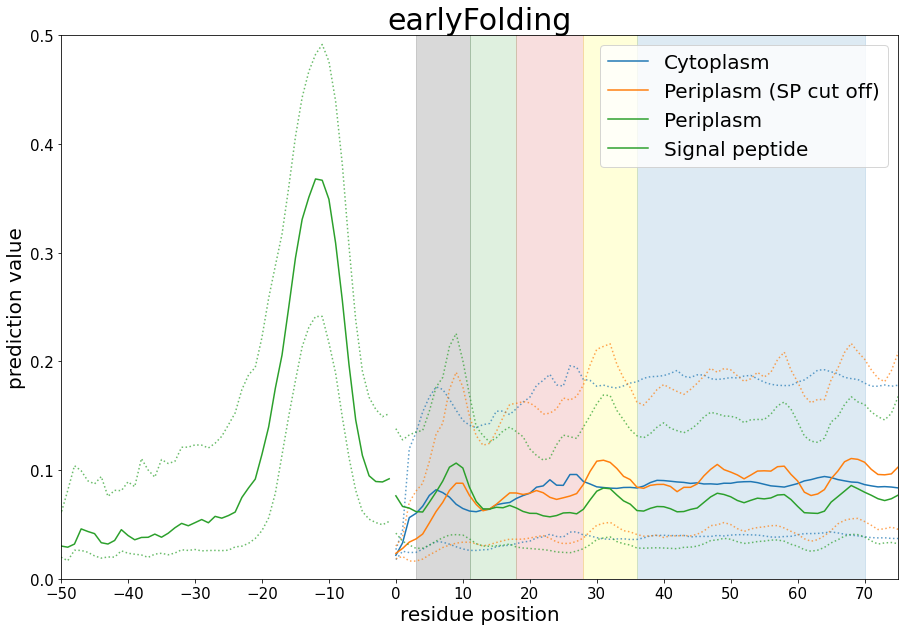

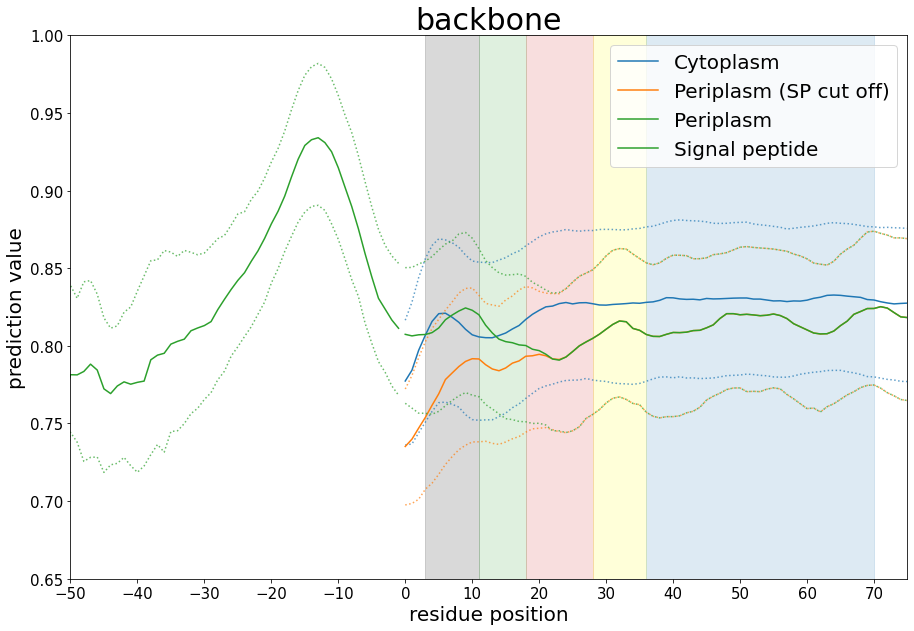

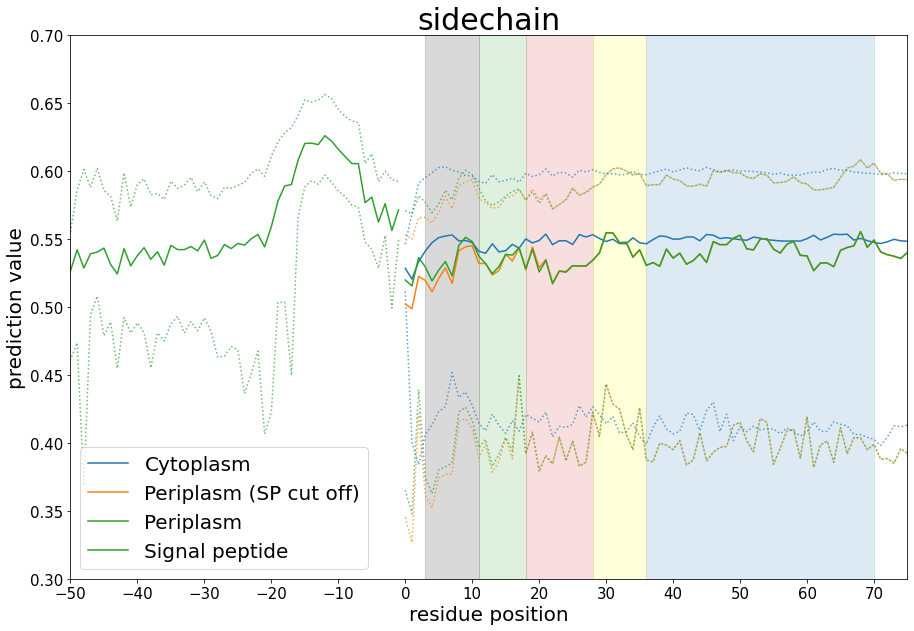

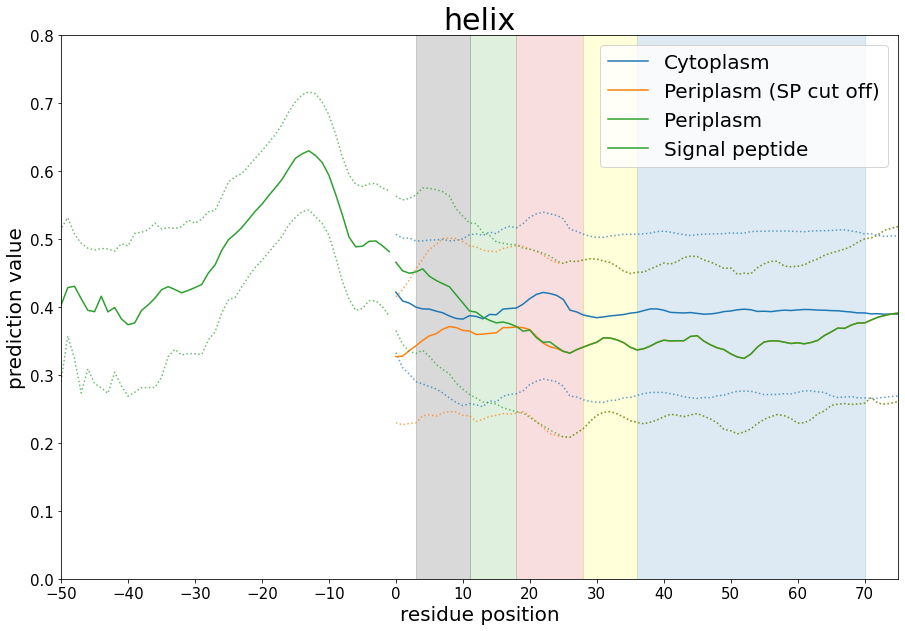

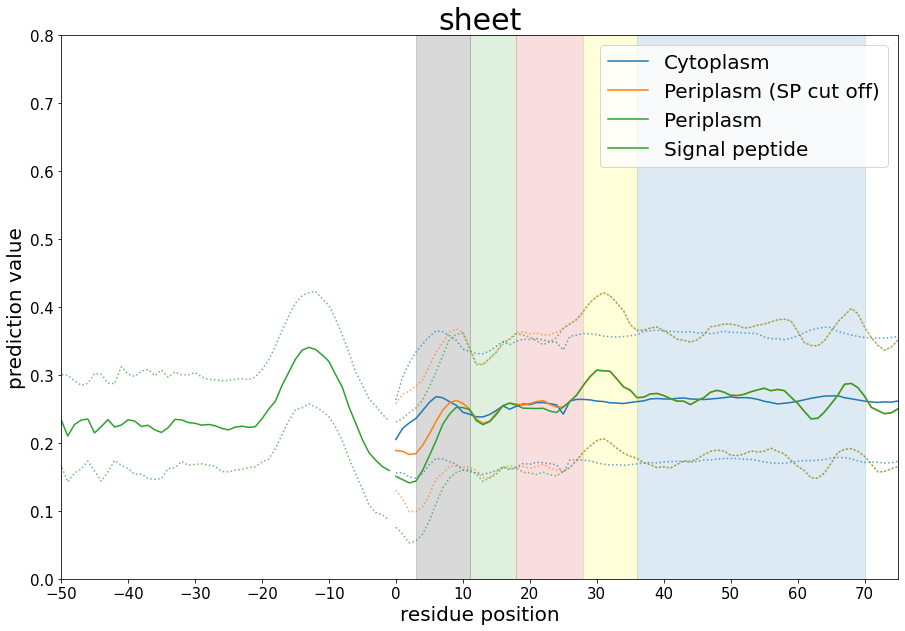

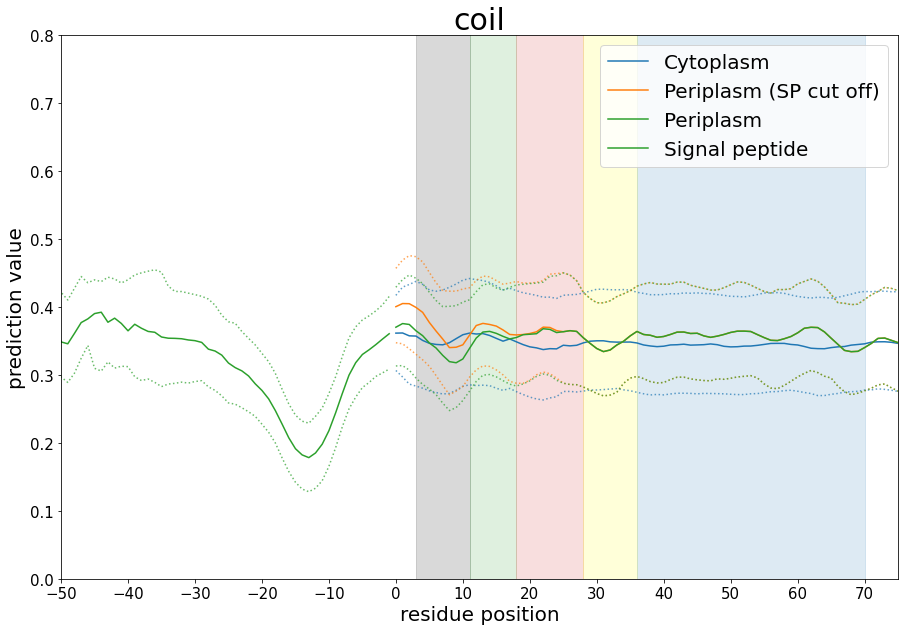

In [13]:
""" Plot the different distributions """
ALPHA_QUADRANT = 0.7
LINE_STYLE_QUADRANT = ":"
ALPHA_REGION = 0.35
COLOR_CYTO ="tab:blue"
COLOR_PERI_WITHOUT="tab:orange"
COLOR_PERI_WITH="tab:green"
COLOR_SP=COLOR_PERI_WITH

FEATURE_GROUPS=[['earlyFolding'],['backbone'],['sidechain'], ['helix'],['sheet'],['coil']]
for FEATURES in FEATURE_GROUPS:
    plt.figure(figsize=(15,10))
    plt.title(" - ".join(FEATURES), fontsize=30)
    plt.xlabel("residue position", fontsize=20)
    plt.ylabel("prediction value", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks(np.arange(-50,200,10))
    plt.xlim((-50,75))    
    for FEATURE in FEATURES:
        CYTO_PERCENTILE25=CYTO_ARRAYS[FEATURE]["percentile25"]
        CYTO_PERCENTILE75=CYTO_ARRAYS[FEATURE]["percentile75"]
        CYTO_MEDIAN=CYTO_ARRAYS[FEATURE]["median"]
        #plt.fill_between(range(len(CYTO_PERCENTILE25)),CYTO_PERCENTILE25,CYTO_PERCENTILE75, 
        #                 alpha=ALPHA_REGION,
        #                 color=COLOR_CYTO,
        #                hatch="x")
        plt.plot(CYTO_PERCENTILE25,
                 color=COLOR_CYTO,
                 alpha=ALPHA_QUADRANT,
                 linestyle=LINE_STYLE_QUADRANT)
        plt.plot(CYTO_PERCENTILE75,
                 color=COLOR_CYTO,
                 alpha=ALPHA_QUADRANT, 
                 linestyle=LINE_STYLE_QUADRANT)
        plt.plot(CYTO_MEDIAN,
                 label="Cytoplasm",
                 color=COLOR_CYTO)
        
        PERI_WITHOUT_PERCENTILE25=PERI_WITHOUT_ARRAYS[FEATURE]["percentile25"]
        PERI_WITHOUT_PERCENTILE75=PERI_WITHOUT_ARRAYS[FEATURE]["percentile75"]
        PERI_WITHOUT_MEDIAN=PERI_WITHOUT_ARRAYS[FEATURE]["median"]
        #plt.fill_between(range(len(PERI_WITHOUT_PERCENTILE25)),PERI_WITHOUT_PERCENTILE25,PERI_WITHOUT_PERCENTILE75, 
        #                 alpha=ALPHA_REGION,
        #                 color=COLOR_PERI_WITHOUT,
        #                 hatch="O")
        plt.plot(PERI_WITHOUT_PERCENTILE25,
                 color=COLOR_PERI_WITHOUT,
                 alpha=ALPHA_QUADRANT, 
                 linestyle=LINE_STYLE_QUADRANT)
        plt.plot(PERI_WITHOUT_PERCENTILE75,
                 color=COLOR_PERI_WITHOUT,
                 alpha=ALPHA_QUADRANT, 
                 linestyle=LINE_STYLE_QUADRANT)
        plt.plot(PERI_WITHOUT_MEDIAN,
                 label="Periplasm (SP cut off)",
                 color=COLOR_PERI_WITHOUT)
        
        PERI_WITH_PERCENTILE25=PERI_WITH_ARRAYS[FEATURE]["percentile25"]
        PERI_WITH_PERCENTILE75=PERI_WITH_ARRAYS[FEATURE]["percentile75"]
        PERI_WITH_MEDIAN=PERI_WITH_ARRAYS[FEATURE]["median"]
        #plt.fill_between(range(len(PERI_WITH_PERCENTILE25)),PERI_WITH_PERCENTILE25,PERI_WITH_PERCENTILE75, 
        #                 alpha=ALPHA_REGION, 
        #                 color=COLOR_PERI_WITH,
        #                hatch=None)
        plt.plot(PERI_WITH_PERCENTILE25, 
                 color=COLOR_PERI_WITH,
                 alpha=ALPHA_QUADRANT, 
                 linestyle=LINE_STYLE_QUADRANT)
        plt.plot(PERI_WITH_PERCENTILE75, 
                 color=COLOR_PERI_WITH,
                 alpha=ALPHA_QUADRANT, 
                 linestyle=LINE_STYLE_QUADRANT)
        plt.plot(PERI_WITH_MEDIAN,
                 label="Periplasm", 
                 color=COLOR_PERI_WITH)
        
        PERI_SP_PERCENTILE25=PERI_SP_ARRAYS[FEATURE]["percentile25"]
        PERI_SP_PERCENTILE75=PERI_SP_ARRAYS[FEATURE]["percentile75"]
        PERI_SP_MEDIAN=PERI_SP_ARRAYS[FEATURE]["median"]
        #plt.fill_between(range(-len(PERI_SP_MEDIAN),0),PERI_SP_PERCENTILE25,PERI_SP_PERCENTILE75, 
        #                 alpha=ALPHA_REGION, 
        #                 color=COLOR_SP,
        #                hatch=None)
        plt.plot(range(-len(PERI_SP_MEDIAN),0),PERI_SP_PERCENTILE25, 
                 color=COLOR_SP,
                 alpha=ALPHA_QUADRANT, 
                 linestyle=LINE_STYLE_QUADRANT)
        plt.plot(range(-len(PERI_SP_MEDIAN),0),PERI_SP_PERCENTILE75, 
                 color=COLOR_SP,
                 alpha=ALPHA_QUADRANT, 
                 linestyle=LINE_STYLE_QUADRANT)
        plt.plot(range(-len(PERI_SP_MEDIAN),0),PERI_SP_MEDIAN,
                 label="Signal peptide", 
                 color=COLOR_SP)
        
        plt.fill_between([3,11],0,1,color="black",alpha=0.15)
        plt.fill_between([11,18],0,1,color="tab:green",alpha=0.15)
        plt.fill_between([18,28],0,1,color="tab:red",alpha=0.15)
        plt.fill_between([28,36],0,1,color="yellow",alpha=0.15)
        plt.fill_between([36,70],0,1,color="tab:blue",alpha=0.15)
        #plt.vlines(46,0,1,color="tab:red")
        #plt.vlines(67,0,1,color="tab:purple")
        
        #plt.fill_between([0,5],0,1,color="black",alpha=0.3)
        
        if FEATURE in ['helix','sheet','coil']:
            plt.ylim((0,0.8))
        elif FEATURE in ["earlyFolding"]:
            plt.ylim((0,0.5))
        elif FEATURE in ["backbone"]:
            plt.ylim((0.65,1.0))
        elif FEATURE in ["sidechain"]:
            plt.ylim((0.3,0.7))
        else:
            plt.ylim()
        
    plt.legend(fontsize=20)
    
    plt.savefig("local_{}.pdf".format(FEATURE), bbox_inches='tight')
    
    plt.show()

In [11]:
""" Plot the different distributions """
FEATURE_GROUPS=[['helix','sheet','coil']]
for FEATURES in FEATURE_GROUPS:
    plt.figure(figsize=(20,10))
    plt.title(" - ".join(FEATURES)+" propensities of the Signal Peptides")
    plt.xlabel("residue position")
    plt.ylabel("prediction value")
    plt.xlim((-50,0))
    for FEATURE in FEATURES:
        PERI_SP_PERCENTILE25=PERI_SP_ARRAYS[FEATURE]["percentile25"]
        PERI_SP_PERCENTILE75=PERI_SP_ARRAYS[FEATURE]["percentile75"]
        PERI_SP_MEDIAN=PERI_SP_ARRAYS[FEATURE]["median"]
        plt.fill_between(range(-len(PERI_SP_MEDIAN),0),PERI_SP_PERCENTILE25,PERI_SP_PERCENTILE75, alpha=0.50)
        plt.plot(range(-len(PERI_SP_MEDIAN),0),PERI_SP_MEDIAN,label=FEATURE)
        
    plt.savefig("local_signal-peptide.pdf
")
    
    plt.legend()
    plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-11-1ef8b1610cfd>, line 16)